In [16]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [17]:
import os

os.sys.path.append("../")

# Simple classifier with different signal samples

We want to see how well a simple $p_T$ based classifier does in the different signals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import seaborn as sns

hep.style.use("CMS")

In [2]:
!ls -lh /home/lucas/Documents/RA/data/

total 31G
-rw-rw-r-- 1 lucas lucas 299M Jan 17 17:11 DY_50k.parquet
-rw-rw-r-- 1 lucas lucas 672M Jan 17 17:11 DY_50k.pkl
-rw-rw-r-- 1 lucas lucas 884K Jan 17 17:11 DY_mc_50k.parquet
-rw-rw-r-- 1 lucas lucas 1.4M Jan 17 17:11 DY_mc_50k.pkl
-rw-rw-r-- 1 lucas lucas 3.2M Jan 17 17:11 DY_mc.parquet
-rw-rw-r-- 1 lucas lucas 5.8M Jan 17 17:11 DY_mc.pkl
-rw-rw-r-- 1 lucas lucas 1.8G Jan 17 17:11 DY.parquet
-rw-rw-r-- 1 lucas lucas 4.0G Jan 17 17:11 DY.pkl
-rw-r--r-- 1 lucas lucas 5.2G Jan 17 14:57 GTT_TrackNtuple_DY.root
-rw-r--r-- 1 lucas lucas 5.9G Jan 17 15:29 GTT_TrackNtuple_TT.root
-rw-r--r-- 1 lucas lucas 1.8G Jan 17 15:13 GTT_TrackNtuple_Zp.root
-rw-rw-r-- 1 lucas lucas 1.8K Jan 17 17:12 process_dataset.py
-rw-rw-r-- 1 lucas lucas  556 Oct  3 12:11 trk1-pt.bin
-rw-rw-r-- 1 lucas lucas  556 Oct  3 12:11 trk1-z0.bin
-rw-r--r-- 1 lucas lucas 168M Oct  3 12:01 trk_processed_25k.pkl
-rw-rw-r-- 1 lucas lucas 377M Jan 17 16:42 ttbar_50k.parquet
-rw-rw-r-- 1 lucas lucas 803M Jan 17 16:42 ttba

In [3]:
storage = "/home/lucas/Documents/RA/data/"
dy = pd.read_parquet(storage + "DY_50k.parquet")
dy_mc = pd.read_parquet(storage + "DY_mc_50k.parquet")

In [4]:
tt = pd.read_parquet(storage + "ttbar_50k.parquet")
tt_mc = pd.read_parquet(storage + "ttbar_mc_50k.parquet")

In [5]:
tt.head()

,event_number,track_number,trk_pt,trk_eta,trk_z0,trk_phi,trk_fake,trk_MVA1,trk_chi2_x,trk_chi2_y,trk_chi2dof,trk_chi2rphi,trk_chi2rz,trk_bendchi2,trk_MVA2,trk_nstub,trk_lhits,trk_dhits,trk_seed
0,0,0,3.321735,1.508114,2.285156,-0.322148,2,0.999705,3.449683,3.449683,0.431210,1.824624,1.625059,0.650641,0.0,6,111,1011,0
1,0,1,2.802182,1.816592,-10.957031,-0.262414,2,0.996890,4.947418,4.947418,0.618427,1.406616,3.540802,1.399517,0.0,6,11,1111,0
2,0,2,2.178730,0.647218,-3.632812,-0.083509,2,0.990228,11.213161,11.213161,1.401645,10.229476,0.983685,1.053935,0.0,6,111111,0,0
3,0,3,1.971232,1.026682,-1.406250,0.047079,2,0.996147,3.593802,3.593802,0.598967,1.705098,1.888704,0.702030,0.0,5,11111,0,0
4,0,4,1.974080,-1.409943,-1.582031,0.263590,2,0.998664,12.148260,12.148260,1.518533,6.264452,5.883808,1.077325,0.0,6,111,111,0


In [6]:
tt.drop(columns="trk_chi2_y", inplace=True)

In [7]:
tt.rename(columns={"trk_chi2_x": "trk_chi2"}, inplace=True)

In [8]:
zp = pd.read_parquet(storage + "Zp_50k.parquet")
zp_mc = pd.read_parquet(storage + "Zp_mc_50k.parquet")

In [9]:
zp_mc.head()

,event_number,track_number,pv_MC
0,0,0,-0.603286
1,1,0,0.597292
2,2,0,0.854938
3,3,0,5.964469
4,4,0,7.255724


In [10]:
dy.dropna(inplace=True)
zp.dropna(inplace=True)
tt.dropna(inplace=True)

In [11]:
tt['is_pv']=0
dy['is_pv']=0
zp['is_pv']=0

tt.loc[tt['trk_fake']==1, 'is_pv']=1
dy.loc[dy['trk_fake']==1,'is_pv']=1
zp.loc[zp['trk_fake']==1,'is_pv']=1

In [12]:
from primaryvertexingtools import generate_roc_curve, test_feature_discrimination

## ttbar logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [13]:
from sklearn.model_selection import train_test_split

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [18]:
ttx_train, ttx_test, tty_train, tty_test = train_test_split(
    tt["trk_pt"].values, tt["is_pv"].values, test_size=0.5, stratify=tt["is_pv"].values
)

In [20]:
tt_clf = LogisticRegression(class_weight="balanced").fit(
    ttx_train.reshape(-1, 1), tty_train
)

In [30]:
tt_pred = tt_clf.predict(ttx_test.reshape(-1, 1))
tt_pred_prob = tt_clf.predict_proba(ttx_test.reshape(-1, 1))[:, 1]

In [31]:
tt_pred

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
cm_tt = confusion_matrix(tty_test, tt_pred, normalize="true")

Text(0.5, 1.0, 'ttbar $p_T$ LR classifier')

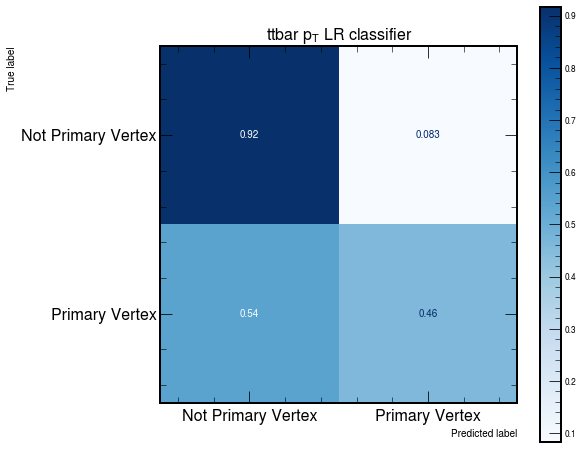

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    tt_pred,
    tty_test,
    display_labels=["Not Primary Vertex", "Primary Vertex"],
    cmap="Blues",
    normalize="true",
    ax=ax,
)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.title("ttbar $p_T$ LR classifier", fontsize=16)

Text(0.5, 1.0, 'ttbar classifier based on $p_T$')

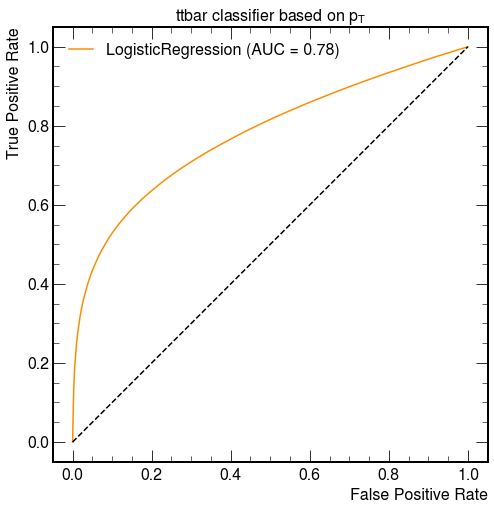

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_estimator(
    tt_clf, ttx_test.reshape(-1, 1), tty_test, color="darkorange", ax=ax
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_title("ttbar classifier based on $p_T$", fontsize=16)

## Drell Yan LR classifier

In [37]:
dyx_train, dyx_test, dyy_train, dyy_test = train_test_split(
    dy["trk_pt"].values, dy["is_pv"].values, test_size=0.5, stratify=dy["is_pv"].values
)

In [38]:
dy_clf = LogisticRegression(class_weight="balanced").fit(
    dyx_train.reshape(-1, 1), dyy_train
)

In [40]:
dy_pred = dy_clf.predict(dyx_test.reshape(-1, 1))
dy_pred_prob = dy_clf.predict_proba(dyx_test.reshape(-1, 1))[:, 1]

Text(0.5, 1.0, 'DY $p_T$ LR classifier')

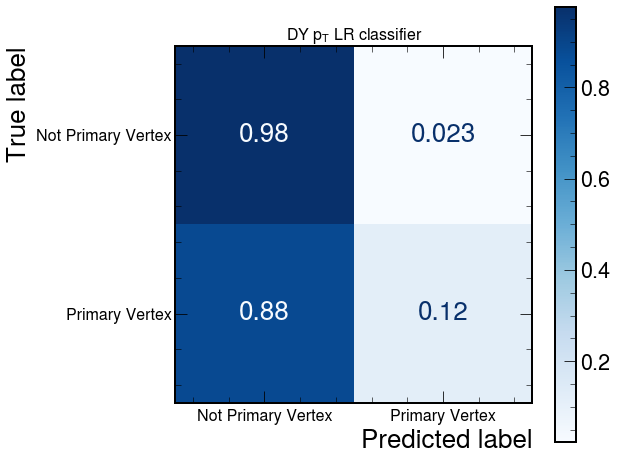

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    dy_pred,
    dyy_test,
    display_labels=["Not Primary Vertex", "Primary Vertex"],
    cmap="Blues",
    normalize="true",
    ax=ax,
)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.title("DY $p_T$ LR classifier", fontsize=16)

Text(0.5, 1.0, 'Drell-Yann classifier based on $p_T$')

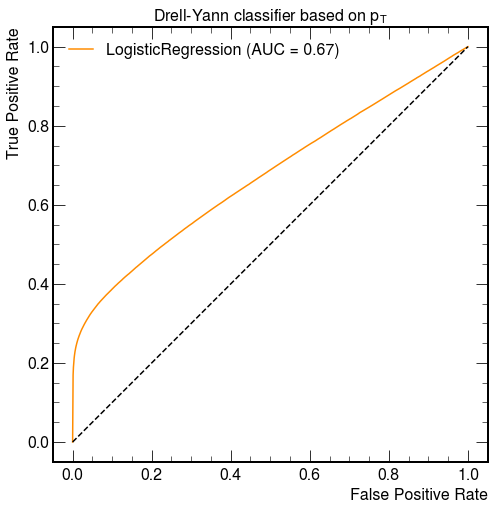

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_estimator(
    dy_clf, dyx_test.reshape(-1, 1), dyy_test, color="darkorange", ax=ax
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_title("Drell-Yann classifier based on $p_T$", fontsize=16)

## Z' $\rightarrow$ $\mu\bar{\mu}$ Logisitc regression classifier

In [43]:
zpx_train, zpx_test, zpy_train, zpy_test = train_test_split(
    zp["trk_pt"].values, zp["is_pv"].values, test_size=0.5, stratify=zp["is_pv"].values
)

In [44]:
zp_clf = LogisticRegression(class_weight="balanced").fit(
    zpx_train.reshape(-1, 1), zpy_train
)

In [45]:
zp_pred = zp_clf.predict(zpx_test.reshape(-1, 1))
zp_pred_prob = zp_clf.predict_proba(zpx_test.reshape(-1, 1))[:, 1]

Text(0.5, 1.0, "Z' $p_T$ LR classifier")

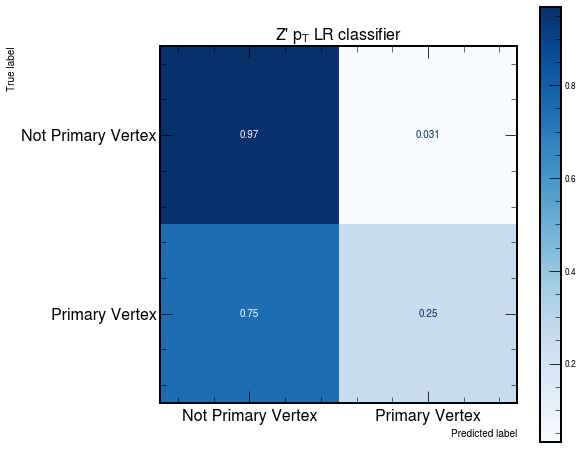

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    zp_pred,
    zpy_test,
    display_labels=["Not Primary Vertex", "Primary Vertex"],
    cmap="Blues",
    normalize="true",
    ax=ax,
)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.title("Z' $p_T$ LR classifier", fontsize=16)

Text(0.5, 1.0, "Z' classifier based on $p_T$")

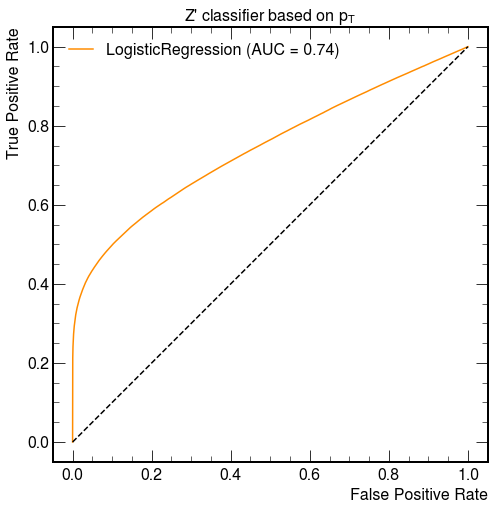

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_estimator(
    zp_clf, zpx_test.reshape(-1, 1), zpy_test, color="darkorange", ax=ax
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_title("Z' classifier based on $p_T$", fontsize=16)

In [13]:
tt.dropna(inplace=True)

In [14]:
tt["is_pv"] = 0

In [15]:
tt.loc[tt["trk_fake"] == 1, "is_pv"] = 1

In [16]:
X = tt["trk_pt"]

In [17]:
y = tt["is_pv"]

In [18]:
X.values

array([3.32, 2.8 , 2.18, ..., 2.65, 2.24, 2.15], dtype=float32)

In [19]:
y.values

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
tt

,event_number,track_number,trk_pt,trk_eta,trk_z0,trk_phi,trk_fake,trk_MVA1,trk_chi2,trk_chi2dof,trk_chi2rphi,trk_chi2rz,trk_bendchi2,trk_MVA2,trk_nstub,trk_lhits,trk_dhits,trk_seed,is_pv
0,0,0,3.321735,1.508114,2.285156,-0.322148,2,0.999705,3.449683,0.431210,1.824624,1.625059,0.650641,0.0,6,111,1011,0,0
1,0,1,2.802182,1.816592,-10.957031,-0.262414,2,0.996890,4.947418,0.618427,1.406616,3.540802,1.399517,0.0,6,11,1111,0,0
2,0,2,2.178730,0.647218,-3.632812,-0.083509,2,0.990228,11.213161,1.401645,10.229476,0.983685,1.053935,0.0,6,111111,0,0,0
3,0,3,1.971232,1.026682,-1.406250,0.047079,2,0.996147,3.593802,0.598967,1.705098,1.888704,0.702030,0.0,5,11111,0,0,0
4,0,4,1.974080,-1.409943,-1.582031,0.263590,2,0.998664,12.148260,1.518533,6.264452,5.883808,1.077325,0.0,6,111,111,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144230,49999,213,1.956761,-0.794572,-8.847656,-0.658581,2,0.583963,6.410769,1.602692,2.490247,3.920522,1.206160,0.0,4,101110,0,2,0
9144231,49999,214,1.974437,2.042241,5.625000,-0.868537,2,0.957060,8.334285,2.083571,2.325773,6.008512,0.926740,0.0,4,1,111,4,0
9144232,49999,215,2.653839,2.266208,-3.515625,-1.143152,2,0.999723,5.724111,0.715514,1.885870,3.838240,0.750637,0.0,6,1,11111,5,0
9144233,49999,216,2.244047,-2.199556,7.792969,-0.692157,2,0.999751,4.317169,0.539646,0.965626,3.351543,1.397967,0.0,6,1,11111,5,0


In [21]:
AUC = test_feature_discrimination(X.values.reshape(-1, 1), y.values)

In [22]:
AUC

0.7765284172514538

## Discriminating features

### ttbar signal

In [23]:
tt.head()

,event_number,track_number,trk_pt,trk_eta,trk_z0,trk_phi,trk_fake,trk_MVA1,trk_chi2,trk_chi2dof,trk_chi2rphi,trk_chi2rz,trk_bendchi2,trk_MVA2,trk_nstub,trk_lhits,trk_dhits,trk_seed,is_pv
0,0,0,3.321735,1.508114,2.285156,-0.322148,2,0.999705,3.449683,0.431210,1.824624,1.625059,0.650641,0.0,6,111,1011,0,0
1,0,1,2.802182,1.816592,-10.957031,-0.262414,2,0.996890,4.947418,0.618427,1.406616,3.540802,1.399517,0.0,6,11,1111,0,0
2,0,2,2.178730,0.647218,-3.632812,-0.083509,2,0.990228,11.213161,1.401645,10.229476,0.983685,1.053935,0.0,6,111111,0,0,0
3,0,3,1.971232,1.026682,-1.406250,0.047079,2,0.996147,3.593802,0.598967,1.705098,1.888704,0.702030,0.0,5,11111,0,0,0
4,0,4,1.974080,-1.409943,-1.582031,0.263590,2,0.998664,12.148260,1.518533,6.264452,5.883808,1.077325,0.0,6,111,111,0,0


In [24]:
features_to_test = [
    "trk_pt",
    "trk_eta",
    "trk_phi",
    "trk_MVA1",
    "trk_chi2",
    "trk_chi2dof",
    "trk_chi2rphi",
    "trk_chi2rz",
    "trk_bendchi2",
    "trk_nstub",
]

In [25]:
y = tt["is_pv"].values
results = {}
for feature in features_to_test:

    X = tt[feature].values
    AUC = test_feature_discrimination(X.reshape(-1, 1), y)

    results[feature] = AUC
print(results)

{'trk_pt': 0.7762355740683966, 'trk_eta': 0.5001663438856434, 'trk_phi': 0.49970591610168325, 'trk_MVA1': 0.5425445415216297, 'trk_chi2': 0.555773422085414, 'trk_chi2dof': 0.5530190870632156, 'trk_chi2rphi': 0.5635392444291911, 'trk_chi2rz': 0.49261362271348824, 'trk_bendchi2': 0.510224874553916, 'trk_nstub': 0.5125598607992086}


In [26]:
for k, v in results.items():
    print(k, v)

trk_pt 0.7762355740683966
trk_eta 0.5001663438856434
trk_phi 0.49970591610168325
trk_MVA1 0.5425445415216297
trk_chi2 0.555773422085414
trk_chi2dof 0.5530190870632156
trk_chi2rphi 0.5635392444291911
trk_chi2rz 0.49261362271348824
trk_bendchi2 0.510224874553916
trk_nstub 0.5125598607992086


### Drell-Yann signal

In [27]:
dy

,event_number,track_number,trk_pt,trk_eta,trk_z0,trk_phi,trk_fake,trk_MVA1,trk_chi2,trk_chi2dof,trk_chi2rphi,trk_chi2rz,trk_bendchi2,trk_MVA2,trk_nstub,trk_lhits,trk_dhits,trk_seed
0,0,0,2.866870,0.113040,9.550781,-0.421606,2,0.999381,4.637965,0.579746,2.702988,1.934977,0.686679,0.0,6,111111,0,0
1,0,1,2.486012,1.845880,0.000000,-0.316801,2,0.215835,137.081711,22.846952,127.351372,9.730344,2.440569,0.0,5,11,1011,0
2,0,2,2.361389,0.307625,3.339844,-0.308614,2,0.997092,3.353733,0.558955,0.709916,2.643817,0.726506,0.0,5,11111,0,0
3,0,3,3.423718,0.095558,9.492188,-0.121366,2,0.999124,5.060819,0.632602,0.270905,4.789914,0.765052,0.0,6,111111,0,0
4,0,4,2.778670,-1.833775,2.636719,-0.068203,2,0.999369,0.922418,0.115302,0.751318,0.171101,1.982557,0.0,6,10,11111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999639,49999,147,2.000825,-2.058559,6.621094,-1.140925,2,0.999376,1.251186,0.156398,0.897767,0.353420,0.642494,0.0,6,1,11111,5
7999640,49999,148,4.460616,-2.361785,-4.570312,-0.836780,2,0.999363,2.357267,0.392878,1.111936,1.245331,1.784898,0.0,5,0,11111,5
7999641,49999,149,2.576263,2.420629,-4.277344,-0.706036,2,0.999110,4.582842,0.763807,0.157715,4.425127,0.746230,0.0,5,0,11111,5
7999642,49999,150,2.010026,-2.218207,3.281250,-0.750119,2,0.999431,10.751022,1.343878,0.940324,9.810699,0.409269,0.0,6,1,11111,5


In [28]:
dy["is_pv"] = 0
dy.loc[dy["trk_fake"] == 1, "is_pv"] = 1

In [29]:
dy.dropna(inplace=True)

In [30]:
y = dy["is_pv"].values
results_dy = {}
for feature in features_to_test:

    X = dy[feature].values
    AUC = test_feature_discrimination(X.reshape(-1, 1), y)

    results_dy[feature] = AUC
    print(feature, AUC)

trk_pt 0.6754841434007948
trk_eta 0.5007164462021292
trk_phi 0.5004212513224963
trk_MVA1 0.5238567974224253
trk_chi2 0.5474562792359684
trk_chi2dof 0.5459341194350281
trk_chi2rphi 0.5554756134762769
trk_chi2rz 0.49774856284599733
trk_bendchi2 0.5088504647567398
trk_nstub 0.5109184492064659


### Z' $\rightarrow$ $\mu$ $\mu$ signal

In [31]:
zp["is_pv"] = 0
zp.loc[zp["trk_fake"] == 1, "is_pv"] = 1
zp.dropna(inplace=True)

In [32]:
y = zp["is_pv"].values
results_zp = {}
for feature in features_to_test:
    X = zp[feature].values
    AUC = test_feature_discrimination(X.reshape(-1, 1), y)
    results_zp[feature] = AUC
    print(feature, round(AUC, 3))

trk_pt 0.744
trk_eta 0.501
trk_phi 0.499
trk_MVA1 0.473
trk_chi2 0.544
trk_chi2dof 0.542
trk_chi2rphi 0.556
trk_chi2rz 0.496
trk_bendchi2 0.514
trk_nstub 0.513


<AxesSubplot:xlabel='trk_MVA1', ylabel='Density'>

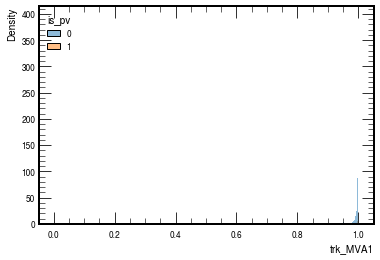

In [33]:
sns.histplot(data=zp, x="trk_MVA1", hue="is_pv", common_norm=True, stat="density")

In [34]:
bkg = zp.loc[zp.is_pv == 0, "trk_MVA1"]
sig = zp.loc[zp.is_pv == 1, "trk_MVA1"]

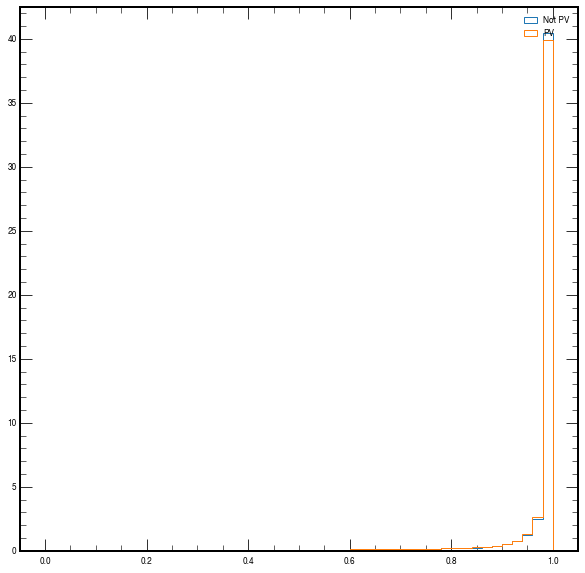

In [35]:
plt.figure(figsize=(10, 10))
_, be, _ = plt.hist(bkg, bins=50, histtype="step", density=True, label="Not PV")
_ = plt.hist(sig, bins=be, histtype="step", density=True, label="PV")
plt.legend()

## Multidimension classifier

In [36]:
from primaryvertexingtools import test_xgb_clf

In [39]:
ttbar_auc, ttbar_clf = test_xgb_clf(tt, features_to_test, label_name="is_pv")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.807 total time=  30.8s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.809 total time=  30.7s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.809 total time=  31.0s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.806 total time= 1.5min
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.807 total time= 1.5min
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.808 total time= 1.5min
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.806 total time= 2.8min
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.807 total time= 2.8min
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.808 total time= 2.9min
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.806 t

In [40]:
ttbar_auc

0.7794276451012123

In [52]:
features_to_test = [
    "trk_pt",
    "trk_eta",
    "trk_phi",
    "trk_MVA1",
    "trk_chi2",
    "trk_chi2dof",
    "trk_chi2rphi",
    "trk_chi2rz",
    "trk_bendchi2",
    "trk_nstub",
]

In [53]:
x_train, x_test, y_train, y_test = train_test_split(
    tt[features_to_test].values,
    tt["is_pv"].values,
    test_size=0.2,
    random_state=42,
    stratify=tt["is_pv"].values,
)

ValueError: X has 10 features, but LogisticRegression is expecting 1 features as input.

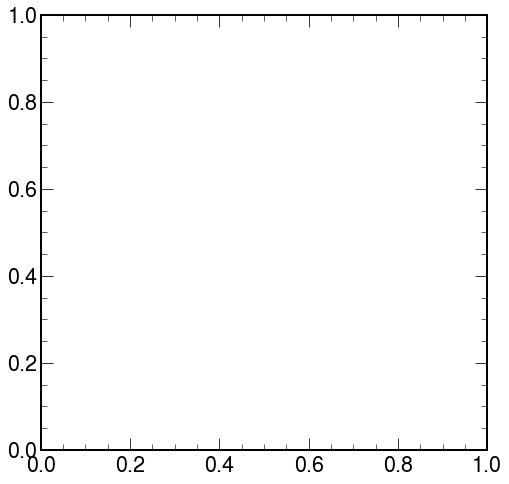

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(
    tt_clf,
    x_test,
    y_test,
    color='darkorange',
    ax=ax
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_title("Classifier based on $p_T$", fontsize=16)

In [ ]:
dy_auc, dy_clf = test_xgb_clf(dy, features_to_test, label_name="is_pv")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.886 total time=  25.9s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.887 total time=  25.9s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.885 total time=  25.6s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.885 total time= 1.2min
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.886 total time= 1.2min
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=150;, score=0.885 total time= 1.2min
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.885 total time= 2.4min
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.886 total time= 2.5min
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.885 total time= 2.4min
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=50;, score=0.890 t

In [42]:
dy_auc

0.6545116990916323

In [ ]:
zp_auc, zp_clf = test_xgb_clf(zp, features_to_test, label_name="is_pv")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.870 total time=  26.1s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.874 total time=  26.9s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=50;, score=0.869 total time=  26.6s
